In [3]:
# Imports
import pandas as pd
import ast
import re
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.cm as cm

### Exploratory Data Analysis

EDA steps:
- Stereotype distribution -> ensure merged dataset is balanced
- Sentence length distribution and removal of outliers -> helps calibrate prompt size and model input limits
- Lexical content per group -> early signal of stereotypical phrasing
    - preprocessing + tokenization + word frequency analysis
- Initial t-SNE plot -> preview embedding structure before full analysis

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Data Preparation and Creation of merged dataset in preprocessing.ipynb file
file_path = '/content/drive/MyDrive/LLM_thesis/merged_dataset.parquet'
merged_df = pd.read_parquet(file_path)

#### Stereotype Distribution

In [ ]:
counts = merged_df['stereotype'].value_counts()
counts

In [ ]:
counts = merged_df['stereotype'].value_counts().sort_index()
percentages = merged_df['stereotype'].value_counts(normalize=True).sort_index() * 100

df_counts = pd.DataFrame({
    "count": counts,
    "percentage": percentages
})
# Mapping stereotype labels and gender groups
label_map = {
    1: "Women are emotional and irrational",
    2: "Women are gentle, kind, and submissive",
    3: "Women are empathetic and caring",
    4: "Women are neat and diligent",
    5: "Women are social",
    6: "Women are weak",
    7: "Women are beautiful",
    8: "Men are tough and rough",
    9: "Men are self-confident",
    10: "Men are professional",
    11: "Men are rational",
    12: "Men are providers",
    13: "Men are leaders",
    14: "Men are childish",
    15: "Men are sexual",
    16: "Men are strong"
}
df_counts["label"] = df_counts.index.map(label_map)
df_counts["group"] = df_counts.index.map(lambda x: "Women" if x <= 7 else "Men")

# Setting colors based on group
color_map = {"Women": "lightpink", "Men": "lightblue"}
colors = df_counts["group"].map(color_map)
# Sorting
df_counts = df_counts.sort_values("count", ascending=True)
colors = colors.loc[df_counts.index]

# Plot
plt.figure(figsize=(12, 8))
bars = plt.barh(df_counts["label"], df_counts["count"], color=colors)
plt.xlabel("Frequency")
plt.title("Stereotype Category Distribution by Gender")

for bar, pct in zip(bars, df_counts["percentage"]):
    plt.text(bar.get_width() + 2, bar.get_y() + bar.get_height()/2, f"{pct:.1f}%", va='center')
plt.tight_layout()
plt.savefig("stereotype_distribution.png", dpi=300)
plt.show()

The distribution of gender stereotypes in the dataset is relatively balanced, with percentages ranging from 5.5 to 7.7, indicating no major outliers and a good representation of all 16 stereotype categories. The most represented stereotype is “Women are empathetic and caring” (7.7%), followed by “Men are tough and rough” (7.1%) and “Women are emotional and irrational” (7.0%). The least represented stereotypes are “Men are childish”, “Women are weak”, and “Women are social”, all around 5.5%.

#### Sentence length distribution

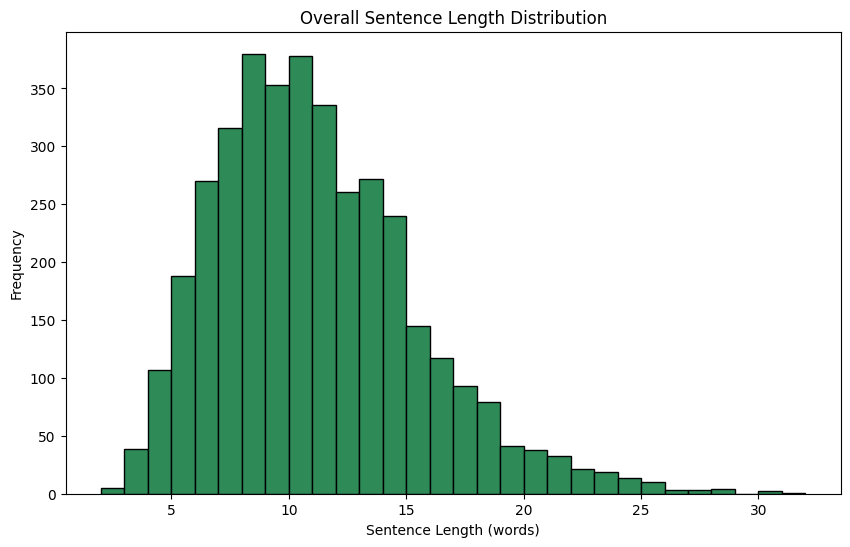

In [11]:
# Computes sentence lengths (word count)
merged_df["length"] = merged_df["sentence"].apply(lambda x: len(str(x).split()))
# Plot histogram for overall sentence lengths
plt.figure(figsize=(10, 6))
plt.hist(merged_df["length"], bins=30, color="seagreen", edgecolor="black")
plt.xlabel("Sentence Length (words)")
plt.ylabel("Frequency")
plt.title("Overall Sentence Length Distribution")
plt.savefig("sentence_length_distribution.png", dpi=300)
plt.show()

Most sentences have around 10 words, with the majority falling under the 6-13 range. A few outliers are evident at both extremes (2 or 30 words).
This indicates a fairly well-distributed sentence length.

In [12]:
# Based on my embedding and prompt-based methodology, removing outliers makes sense. Outliers may distort cosine similarity scores, especially during average pooling.
# Computing Q1, Q3, and IQR
q1 = merged_df["length"].quantile(0.25)
q3 = merged_df["length"].quantile(0.75)
iqr = q3 - q1

# Defining outlier bounds
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filtering the dataset
filtered_df = merged_df[(merged_df["length"] >= lower_bound) & (merged_df["length"] <= upper_bound)]

print(f"Original size: {merged_df.shape[0]}")
print(f"Filtered size: {filtered_df.shape[0]}")
print(f"Removed outliers: {merged_df.shape[0] - filtered_df.shape[0]}")

Original size: 3768
Filtered size: 3658
Removed outliers: 110


In [13]:
filtered_df.to_parquet("filtered_df.parquet", index=False) #save to parquet

#### Sentence preprocessing, tokenization & word frequency analysis

In [ ]:
nltk.download('punkt_tab')


In [ ]:
# Defining stopwords with some additions
stop_words = set(stopwords.words("english"))
additional_stops = {"like", "could", "would", "im", "get", "got", "one", "also", "dont", "didnt", "even", "always", "never"}
stop_words.update(additional_stops)

# Preprocessing and tokenizing all sentences
def preprocess(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)  # removes punctuation
    tokens = word_tokenize(text)
    return [t for t in tokens if t not in stop_words]

tokens = []
for sentence in filtered_df["sentence"]:
    tokens.extend(preprocess(sentence))

# Counting word frequencies
word_counts = Counter(tokens)
freq_df = pd.DataFrame(word_counts.items(), columns=["word", "count"]).sort_values(by="count", ascending=False)

# Show top and bottom 15
print("Most frequent words:\n", freq_df.head(15))
print("\nLeast frequent words:\n", freq_df.tail(15))

In [ ]:
freq_df.to_csv("word_frequencies.csv", index=False)

In [ ]:
# Now let's see the top 5 words per stereotype category:
stereotype_top_words = {}

# Looping through each stereotype category
for cat in sorted(filtered_df["stereotype"].unique()):
    cat_sentences = filtered_df[filtered_df["stereotype"] == cat]["sentence"]

    tokens = []
    for sentence in cat_sentences:
        tokens.extend(preprocess(sentence))

    word_counts = Counter(tokens)
    top_words = word_counts.most_common(5)

    stereotype_top_words[cat] = top_words

for cat, words in stereotype_top_words.items():
    print(f"Stereotype {cat}: {words}")

The top 5 most frequent words in each stereotype category strongly align with the associated stereotype label. For example, Stereotype 3 (“Women are empathetic and caring”) includes care, help, and children, while Stereotype 10 (“Men are professional”) includes work, job and professional. These lexical patterns validate the mappings I made from StereoSet to GEST, confirming that the merged dataset preserves semantic coherence across categories.

#### Initial t-SNE plot -> Preview embedding structure before full analysis

Sources:
- https://huggingface.co/docs/transformers/en/model_doc/gpt2
- https://stackoverflow.com/questions/77748737/how-to-calculate-word-and-sentence-embedding-using-gpt-2
- https://stackoverflow.com/questions/52849890/how-to-implement-t-sne-in-a-model

#### Starting with gpt-2

In [ ]:
import torch
from transformers import GPT2Tokenizer, GPT2Model
from sklearn.manifold import TSNE
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
model = GPT2Model.from_pretrained("openai-community/gpt2")

In [ ]:
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
# Getting average-pooled sentence embedding from GPT-2
def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        last_hidden_state = outputs.last_hidden_state
        embedding = last_hidden_state.mean(dim=1).squeeze()
    return embedding.cpu().numpy()

In [ ]:
# Extracting embeddings for all sentences
embeddings = []
for sentence in tqdm(filtered_df["sentence"], desc="Extracting GPT-2 embeddings"):
    emb = get_embedding(sentence)
    embeddings.append(emb)

In [ ]:
embeddings_df = pd.DataFrame(embeddings)  # shape = (n_sentences, 768)
embeddings_df["stereotype"] = filtered_df["stereotype"].values # added 1 col
embeddings_df.shape

In [ ]:
# Applying t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(embeddings_df.drop(columns=["stereotype"]).values)
embeddings_df["tsne_x"] = tsne_result[:, 0]
embeddings_df["tsne_y"] = tsne_result[:, 1]

In [ ]:
# Plot
plt.figure(figsize=(8, 6))
for cat in sorted(embeddings_df["stereotype"].unique()):
    subset = embeddings_df[embeddings_df["stereotype"] == cat]
    plt.scatter(subset["tsne_x"], subset["tsne_y"], label=f"Cat {cat}", alpha=0.7)
plt.title("t-SNE of GPT-2 Embeddings")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.savefig("GPT-2_Embeddings.png", dpi=300)
plt.show()

I don't see any clusters forming, I think 16 categories might be too many for a 2D representation so that's why they are not separating clearly. Lets try clustering my gender so from categories 1-7 (female stereotypes) and 8-16 (male stereotypes).

In [ ]:
embeddings_df["gender_group"] = embeddings_df["stereotype"].apply(lambda x: "Women" if x <= 7 else "Men")

plt.figure(figsize=(8, 6))
for group in sorted(embeddings_df["gender_group"].unique()):
    subset = embeddings_df[embeddings_df["gender_group"] == group]
    plt.scatter(subset["tsne_x"], subset["tsne_y"], label=group, alpha=0.7)
plt.title("t-SNE of GPT-2 Embeddings by Gender Group")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.savefig("GPT-2_Embeddings_gender.png", dpi=300)
plt.show()

The t-SNE plot shows overlapping male and female stereotype embeddings in GPT-2, suggesting no clear separation at the sentence level. This motivates deeper analysis (e.g., cosine similarity, prompt completions) to uncover more subtle forms of gender bias.

### Changing baseline to BERT

In [9]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from sklearn.manifold import TSNE
from tqdm import tqdm

In [ ]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_name).to(device)
model.eval()

In [17]:
# Getting average-pooled sentence embedding from BERT (e.g. layer 8) -> middle layers best represent sentence-level semantics
def get_bert_embedding(text, layer=8):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
        hidden_states = outputs.hidden_states
    layer_output = hidden_states[layer][0]  # shape: (seq_len, hidden_dim)
    sentence_embedding = layer_output.mean(dim=0).cpu().numpy()
    return sentence_embedding

In [18]:
# Extracting embeddings for all sentences
embeddings = []
for sentence in tqdm(filtered_df["sentence"], desc="Extracting BERT embeddings"):
    emb = get_bert_embedding(sentence)
    embeddings.append(emb)

Extracting BERT embeddings: 100%|██████████| 3658/3658 [08:40<00:00,  7.03it/s]


In [19]:
embeddings_df = pd.DataFrame(embeddings)  # shape = (n_sentences, 768)
embeddings_df["stereotype"] = filtered_df["stereotype"].values # added 1 col
embeddings_df.shape

(3658, 769)

In [20]:
# Applying t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(embeddings_df.drop(columns=["stereotype"]).values)
embeddings_df["tsne_x"] = tsne_result[:, 0]
embeddings_df["tsne_y"] = tsne_result[:, 1]

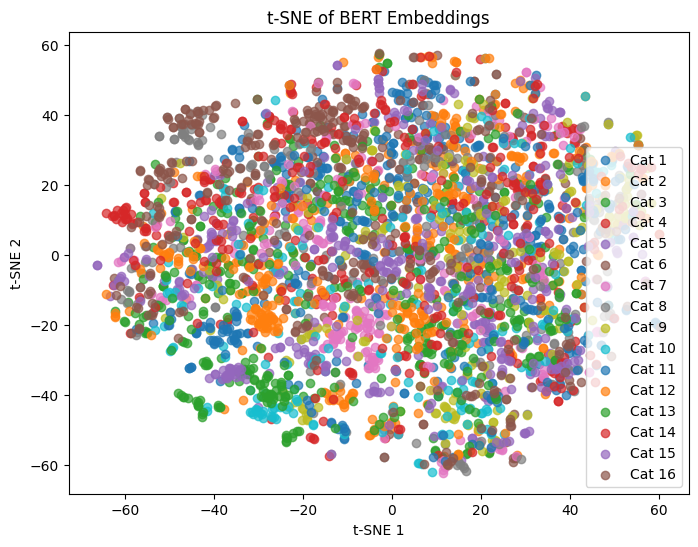

In [22]:
# Plot
plt.figure(figsize=(8, 6))
for cat in sorted(embeddings_df["stereotype"].unique()):
    subset = embeddings_df[embeddings_df["stereotype"] == cat]
    plt.scatter(subset["tsne_x"], subset["tsne_y"], label=f"Cat {cat}", alpha=0.7)
plt.title("t-SNE of BERT Embeddings")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.savefig("BERT_Embeddings.png", dpi=300)
plt.show()

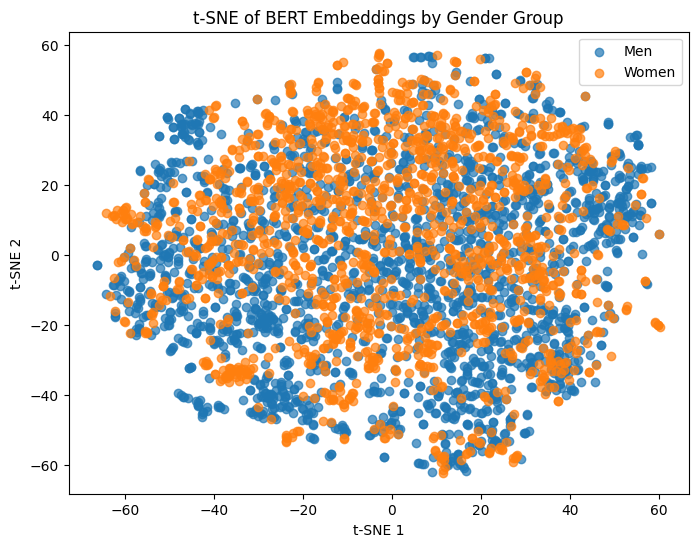

In [23]:
# Embeddings per gender group, men and women stereotypes
embeddings_df["gender_group"] = embeddings_df["stereotype"].apply(lambda x: "Women" if x <= 7 else "Men")

plt.figure(figsize=(8, 6))
for group in sorted(embeddings_df["gender_group"].unique()):
    subset = embeddings_df[embeddings_df["gender_group"] == group]
    plt.scatter(subset["tsne_x"], subset["tsne_y"], label=group, alpha=0.7)
plt.title("t-SNE of BERT Embeddings by Gender Group")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.savefig("BERT_Embeddings_gender.png", dpi=300)
plt.show()

### Now LLaMA 2

In [ ]:
from huggingface_hub import login
login()

In [ ]:
model_id = "meta-llama/Llama-2-7b-chat-hf"

llama_tokenizer = AutoTokenizer.from_pretrained(model_id)
llama_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    device_map="auto"            # automatically sends model to GPU if available
)
llama_model.eval()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
llama_model.to(device)

In [ ]:
# # Getting average-pooled sentence embedding from LlaMA-2 -> similar struct to gpt-2 but the hidden layers are called differently
def get_llama2_embedding(text, model, tokenizer, device):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
        hidden_states = outputs.hidden_states[-1]  # last layer
        embedding = hidden_states.mean(dim=1).squeeze()
    return embedding.cpu().numpy()

# Extracting embeddings for all sentences
llama_embeddings = []
for sentence in tqdm(filtered_df["sentence"], desc="Extracting LLaMA embeddings"):
    emb = get_llama2_embedding(sentence, llama_model, llama_tokenizer, device)
    llama_embeddings.append(emb)

In [ ]:
embeddings_llama = pd.DataFrame(llama_embeddings)  # shape
embeddings_llama["stereotype"] = filtered_df["stereotype"].values # added 1 col
embeddings_llama.shape

In [ ]:
# Applying t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(embeddings_llama.drop(columns=["stereotype"]).values)
embeddings_llama["tsne_x"] = tsne_result[:, 0]
embeddings_llama["tsne_y"] = tsne_result[:, 1]

In [ ]:
# Get unique categories
categories = sorted(embeddings_llama["stereotype"].unique())
num_categories = len(categories)

# Use a colormap with enough distinguishable colors
cmap = cm.get_cmap('tab20', num_categories)

# Plot
plt.figure(figsize=(10, 8))
for i, cat in enumerate(categories):
    subset = embeddings_llama[embeddings_llama["stereotype"] == cat]
    plt.scatter(
        subset["tsne_x"],
        subset["tsne_y"],
        label=f"Cat {cat}",
        color=cmap(i),
        alpha=0.7,
        s=30
    )

plt.title("t-SNE of LLaMA Embeddings")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.tight_layout()
plt.savefig("LlaMA_Embeddings.png", dpi=300)
plt.show()

Since GPT-2 had embeddings that were very uniformly spread I didn't think it was necessary to specifically look into the different points. But, for LLaMA-2, I ensured that each category was assigned a distinct color to better differentiate the points in the t-SNE plot.
Around tsne 0 there is a cluster of Cat 4 (Women are neat and diligent).
I can also observe more clusters of Cat 6 throughout the plot. There is one specifically at around tsne1 40 to 60, tsn2 0.
These clusters may indicate that the model has more structured internal representations of certain stereotypes and may be more susceptible towards biased associations. This highlights the need to delve deeper!


In [ ]:
embeddings_llama["gender_group"] = embeddings_llama["stereotype"].apply(lambda x: "Women" if x <= 7 else "Men")

plt.figure(figsize=(8, 6))
for group in sorted(embeddings_llama["gender_group"].unique()):
    subset = embeddings_llama[embeddings_llama["gender_group"] == group]
    plt.scatter(subset["tsne_x"], subset["tsne_y"], label=group, alpha=0.7)
plt.title("t-SNE of LLaMA-2 Embeddings by Gender Group")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.savefig("LlaMA_Embeddings_group.png", dpi=300)
plt.show()

In this plot, the orange dots (Women) seem to concentrate more around 0 to -40 for tsne2 an between -20 to 20 for tsn1, while some blue areas (Men) show up on the far right (t-SNE 1 from 40 to 60). It’s not a perfect separation, but it's clearer than what I observed with GPT-2.

This suggests that LLaMA-2 might already be encoding some gender-related differences in its embeddings. So even before doing anything more complex like cosine similarity or prompt completions, the embeddings already hint at underlying biases or at least a better internal differentiation between stereotype-related embeddings— which makes a stronger case for looking deeper.

### Conclusions from EDA:

##### - Stereotype Category Distribution:
    - All 16 stereotype categories are well represented in the dataset, ranging from 206 to 290 instances each.
    - No major imbalances were found, which ensures fairness and robustness for downstream analysis.
##### - Sentence Length Distribution:
    - Most sentences are around 5-15 words long.
    - A few outliers (very short or very long sentences) were identified and removed (~110 sentences) to prevent noise in embedding generation.
##### - Word Frequency Analysis:
    - Words like care, home, and felt were more common in Women stereotypes, while work, money, and team were more frequent in Men stereotypes.
    - Per-category analysis further confirmed that the most frequent words aligned well with the stereotype labels, validating the mapping from StereoSet to GEST.
##### - t-SNE Visualization – GPT-2 vs LLaMA-2 Embeddings:
    - GPT-2 embeddings showed little structure; all stereotype categories and gender groups were highly intermixed.
    - LLaMA-2 embeddings revealed more noticeable clusters. This clustering suggests that LLaMA-2 is already encoding stereotypical signals in its internal representation space — even before any generation or classification step.
##### - Justification of research question:
    - These EDA results provide early evidence that large language models like LLaMA-2 may internalize gender biases at the embedding level.
    - The differences between GPT-2 and LLaMA-2 also highlight the potential impact of instruction tuning on how stereotypes are encoded.
    - This strongly justifies a deeper investigation into how and where gender stereotypes are represented — comparing both prompt-based outputs and internal embeddings — as outlined in the rest of the study.